In [21]:
from matplotlib import image
import matplotlib.pyplot as plt
import numpy as np
import torch

%load_ext autoreload
%autoreload 2

from IPython.display import clear_output 
clear_output(wait = True)
import sys 
sys.path.append('..')
from models import LocationScaleFlow, SoftmaxWeight, SoftmaxWeightOver,DIFDensityEstimator, MixedModelDensityEstimator, RealNVPDensityEstimatorLayer, MultivariateNormalReference, EMDensityEstimator
from utils.color_visual import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(256, 197, 3)


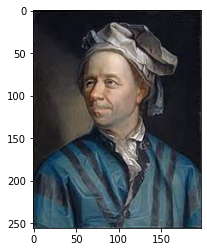

In [22]:
rgb = image.imread("euler.jpg")
plt.imshow(rgb)
print(rgb.shape)

<ipython-input-23-fa747eb203be>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.imshow(torch.tensor(grey))


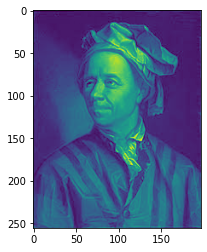

In [23]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
grey = torch.tensor(rgb2gray(rgb))
plt.imshow(torch.tensor(grey))

<ipython-input-30-391ea0fdc117>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vector_density = torch.tensor(grey).flatten()
<ipython-input-30-391ea0fdc117>:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  target_samples = torch.cat([(categorical_samples//colonnes).unsqueeze(-1), (categorical_samples%colonnes).unsqueeze(-1)], dim = -1) + torch.rand([num_samples,2])


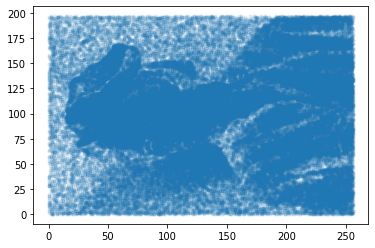

In [30]:
vector_density = torch.tensor(grey).flatten()
vector_density = vector_density/torch.sum(vector_density)
lignes, colonnes = grey.shape
num_samples = 200000
cat = torch.distributions.Categorical(probs = vector_density)
categorical_samples = cat.sample([num_samples])
target_samples = torch.cat([(categorical_samples//colonnes).unsqueeze(-1), (categorical_samples%colonnes).unsqueeze(-1)], dim = -1) + torch.rand([num_samples,2])
plt.scatter(target_samples[:,0], target_samples[:, 1], alpha = .1, marker = '.')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [16:49<00:00, 20.18s/it, loss = 10.597234725952148]


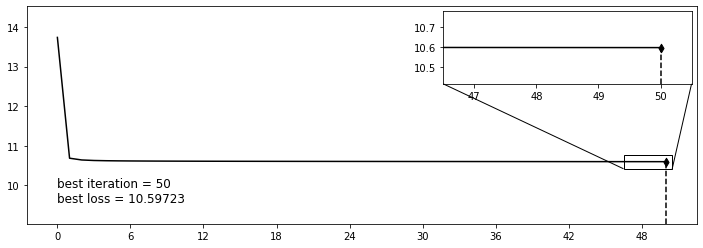

In [43]:
num_samples = target_samples.shape[0]
epochs = 50
K = 900
initial_mu = torch.cartesian_prod(torch.linspace(0, lignes,30),torch.linspace(0, colonnes, 30))
initial_T = LocationScaleFlow(K, 2, initial_m = initial_mu, mode = 'full_rank')
EM = EMDensityEstimator(target_samples,K, initial_T = initial_T)
loss_values = EM.train(epochs,visual=True)

In [44]:
import pickle
filename = 'EM.sav'
pickle.dump(EM,open(filename,'wb'))

PicklingError: Can't pickle <class 'models.location_scale_flow.LocationScaleFlow'>: it's not the same object as models.location_scale_flow.LocationScaleFlow

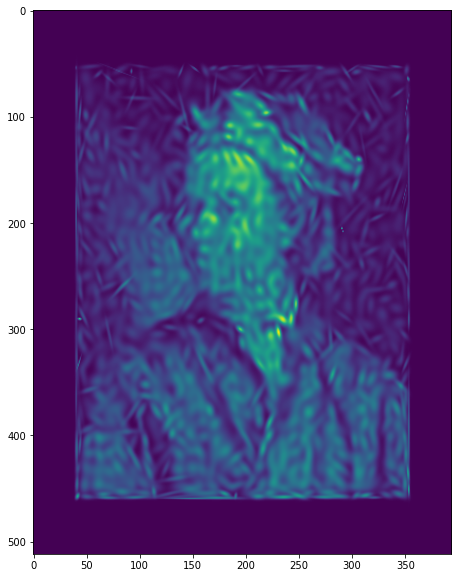

In [45]:
delta = 300
grid = torch.cartesian_prod(torch.linspace(-lignes/8, 1.125*lignes,2*lignes),torch.linspace(-colonnes/8, 1.125*colonnes, 2*colonnes))
density = torch.exp(EM.log_density(grid)).reshape(2*lignes,2*colonnes).T.cpu().detach()
fig = plt.figure(figsize =(10,10))
plt.imshow(torch.flip(torch.flip(density.T,[0,1]),[0,1]))

In [48]:
from torch import nn
num_samples = target_samples.shape[0]
epochs = 100
batch_size = 1000
initial_T = EM.T
initial_w = SoftmaxWeightOver(K, 2, [], mode = 'NN')
initial_w.f[-1].weight = nn.Parameter(torch.zeros(K, 2))
initial_w.f[-1].bias = nn.Parameter(EM.log_pi)
dif = DIFDensityEstimator(target_samples,K, initial_T= initial_T, initial_w = initial_w)
dif = DIFDensityEstimator(target_samples,50)
loss_values = dif.train(epochs,batch_size,visual=True)
dif.model_visual()

 12%|██████████████▌                                                                                                          | 12/100 [02:33<18:44, 12.78s/it, loss = 11.177748680114746]


KeyboardInterrupt: 

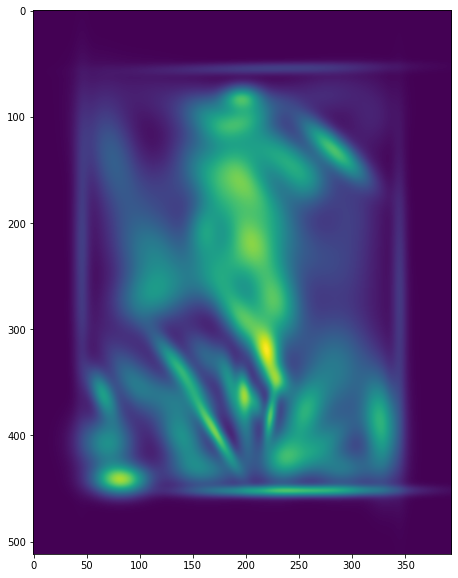

In [10]:
delta = 300
grid = torch.cartesian_prod(torch.linspace(-lignes/8, 1.125*lignes,2*lignes),torch.linspace(-colonnes/8, 1.125*colonnes, 2*colonnes))
density = torch.exp(EM.log_density(grid)).reshape(2*lignes,2*colonnes).T.cpu().detach()
fig = plt.figure(figsize =(10,10))
plt.imshow(torch.flip(torch.flip(density.T,[0,1]),[0,1]))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [52:06<00:00, 15.63s/it, loss = 10.597043991088867]


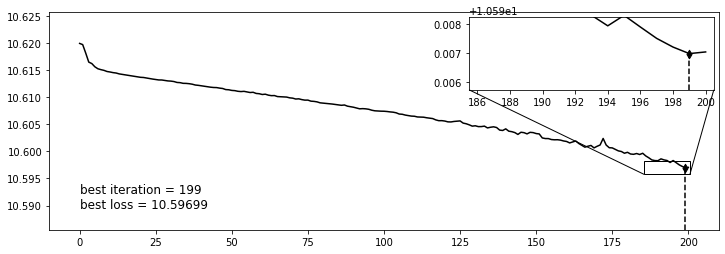

In [9]:
loss_values = dif.train(2*epochs,10000,visual=True)

In [13]:
print(-torch.mean(EM.log_density(target_samples)))
print(dif.loss(target_samples))

tensor(10.6803, grad_fn=<NegBackward0>)
tensor(10.5970, grad_fn=<NegBackward0>)
